# SPTcl-IRAGN Completeness Simulation Plot
## Author: Benjamin Floyd

Generates a publication plot of the completeness simulation recovery curves.

In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 14})

In [12]:
# Completeness simulation result files
sptsz_file = 'Data_Repository/Project_Data/SPT-IRAGN/Comp_Sim/SPT-SZ_2500d/Results/SPTSZ_I2_results_gaussian_fwhm2.02_corr-0.11_mag0.2.json'
sptpol_file = 'Data_Repository/Project_Data/SPT-IRAGN/Comp_Sim/SPTpol_100d/Results/SPTpol_I2_results_gaussian_fwhm2.02_corr-0.11_mag0.2.json'
sdwfs_file = 'Data_Repository/Project_Data/SPT-IRAGN/Comp_Sim/SDWFS/Results/I2_results_gaussian_fwhm172_corr005_mag02_final.npy'

# Read in the numpy save file
sdwfs = np.load(sdwfs_file, encoding='latin1', allow_pickle=True).item()

# Read in the json files
with open(sptsz_file, 'r') as sptsz_f, open(sptpol_file, 'r') as sptpol_f:
    sptsz = json.load(sptsz_f)
    sptpol = json.load(sptpol_f)

In [13]:
# Because the SPT-SZ results are stored using observed ids not the official ids, we need to load in a look-up dictionary
with open('Data_Repository/Project_Data/SPT-IRAGN/Misc/SPT-SZ_observed_to_official_ids.json', 'r') as f:
    obs_to_official_ids = json.load(f)

In [14]:
# Remove any cluster we've already determined unusable
spt_sz_clusters_to_exclude = {'SPT-CLJ0045-5757', 'SPT-CLJ0201-6051', 'SPT-CLJ0230-4427', 'SPT-CLJ0456-5623',
                              'SPT-CLJ0646-6236', 'SPT-CLJ2017-5936', 'SPT-CLJ2133-5410', 'SPT-CLJ2138-6317',
                              'SPT-CLJ2232-6151', 'SPT-CLJ2332-5358', 'SPT-CLJ2341-5726'}
sptpol_clusters_to_exclude = {'SPT-CLJ0002-5214', 'SPT-CLJ2341-5640', 'SPT-CLJ2357-5953'}
for cluster_id in spt_sz_clusters_to_exclude:
    sptsz.pop(cluster_id, None)
for cluster_id in sptpol_clusters_to_exclude:
    sptpol.pop(cluster_id, None)

In [15]:
# Convert all the SPT-SZ keys to official IDs
sptsz = {obs_to_official_ids.get(sz_id, sz_id): data for sz_id, data in sptsz.items()}

In [16]:
# Remove the magnitude bins
magnitude_bins_spt = np.array(sptsz.pop('magnitude_bins', None)[:-1]) + 0.25
del sptpol['magnitude_bins']
magnitude_bins_sdwfs = sdwfs.pop('magnitude_bins', None)[:-1]

In [17]:
# Merge the cluster samples perfering the SPT-SZ (targeted obs) values over the SPTpol (SSDF cutout) values.
sptcl = {**sptpol, **sptsz}

In [18]:
# Compute the median curves for both the SDWFS and SPT samples
mean_sdwfs = np.mean(list(list(curve) for curve in sdwfs.values()), axis=0)
mean_sptcl = np.mean(list(list(curve) for curve in sptcl.values()), axis=0)

In [19]:
from scipy.interpolate import interp1d
sptcl_curve = interp1d(np.mean(list(list(curve) for curve in sptcl.values()), axis=0), magnitude_bins_spt)
completeness_magnitude_limit = sptcl_curve(0.8)
completeness_magnitude_limit

array(17.4785577)

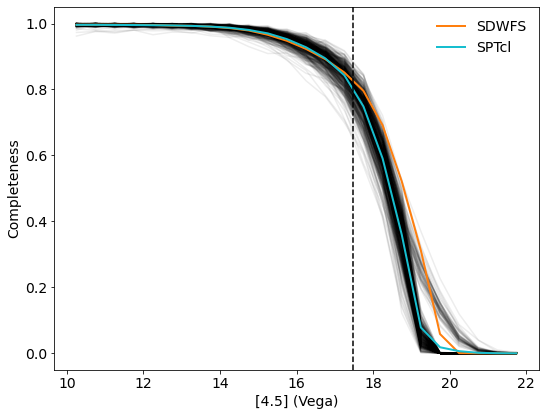

In [20]:
# Make plot
fig, ax = plt.subplots(figsize=(7.8, 6))
for curve in sptcl.values():
    ax.plot(magnitude_bins_spt, curve, color='k', alpha=0.07)
ax.plot(magnitude_bins_sdwfs, mean_sdwfs, color='tab:orange', lw=2, label='SDWFS')
ax.plot(magnitude_bins_spt, mean_sptcl, color='tab:cyan', lw=2, label='SPTcl')
# ax.fill_between(magnitude_bins_spt, min_curve_sptcl, max_curve_sptcl, color='C1', alpha=0.3)
ax.axvline(x=17.48, color='k', linestyle='--', alpha=1.)
ax.set(xlabel='[4.5] (Vega)', ylabel='Completeness')
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SPTcl_SDWFS_completeness_sim_publication.pdf')